# GMM in PCA space of ensemble of reanalysis datasets

In [1]:
from importlib import reload
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy as ctp
import seaborn as sns
from sklearn import mixture, decomposition

from latgmm.utils import utenso, preproc, eof, utdata, utstats, metric
import latgmm.geoplot as gpl

plt.style.use("../../paper.mplstyle")

## Load data

In [2]:
# Load data
# =======================================================================================
reload(preproc)
varname='sst'
lon_range=[130, -70]
lat_range=[-31, 32]
grid_step = 1
climatology='month'
detrend_from = None

dirpath = "../../data/reanalysis/monthly/"
datapath = {
    'sst': dirpath+"/HadISST/sst_hadisst_month_1870-present.nc",
}

da_arr = []
for var, path in datapath.items():
    print(f"Load {var}")
    temp = preproc.process_data(
        path, vars=[var], antimeridian=True,
        lon_range=lon_range, lat_range=lat_range,
        grid_step=grid_step, climatology=climatology,
        detrend_from=detrend_from, normalization=None
    )
    temp = temp[f"{var}a"]
    temp['time'] = np.array(temp['time'].data, dtype='datetime64[M]')
    da_arr.append(temp)
ds = xr.merge(da_arr)

Load sst
Sort longitudes and latitudes in ascending order, respectively
Process sst:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-31, 32]!
Interpolate grid on res 1
Detrend and compute anomalies:


/tmp/ipykernel_63438/3745646160.py:26: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp['time'] = np.array(temp['time'].data, dtype='datetime64[M]')
/tmp/ipykernel_63438/3745646160.py:26: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by convert

In [3]:
ds = ds.sel(time=slice(None, '2010-12-01'))

<xarray.Dataset>
Dimensions:  (time: 1692, lat: 64, lon: 160)
Coordinates:
  * time     (time) datetime64[ns] 1870-01-01 1870-02-01 ... 2010-12-01
  * lat      (lat) int64 -31 -30 -29 -28 -27 -26 -25 ... 26 27 28 29 30 31 32
  * lon      (lon) int64 -50 -49 -48 -47 -46 -45 -44 ... 104 105 106 107 108 109
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ssta     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

### Compute EOFs of narrow band and project on E/C

In [4]:
ds4eof = ds.copy().sel(lat=slice(-10, 10), time=slice('1979-01-01', '2009-12-01'))

n_components = 2
sppca = eof.SpatioTemporalPCA(ds4eof, n_components=n_components)
print(f"Explained variance: {np.sum(sppca.explained_variance())}")
sppca.pca.components_[1] *= -1
eofs = sppca.get_eofs()
pcs = sppca.get_principal_components()

Explained variance: 0.825573164087672


Plot EOF maps.

/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


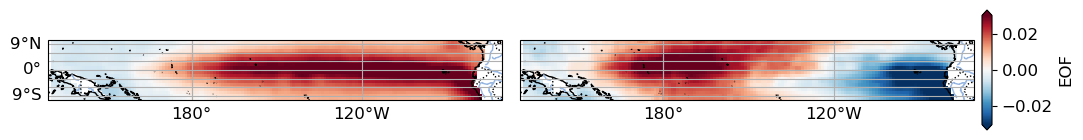

In [5]:
# EOF maps
vars = list(ds.data_vars)
fig = plt.figure(figsize=(10, 2*len(vars)))
proj = ctp.crs.PlateCarree(central_longitude=180)
axs = []
for i in range(sppca.n_components):
    comp = eofs.isel(eof=i)
    for j, var in enumerate(vars):
        ax = fig.add_subplot(len(vars), sppca.n_components, i+sppca.n_components*j+1, projection=proj)
        im = gpl.plot_map(comp[var], central_longitude=180, ax=ax,
                     bar='continuous', vmin=-.03, vmax=.03, add_bar=False)
        im['gl'].top_labels = False 
        if i > 0:
            im['gl'].left_labels = False 
        axs.append(ax)
        
cbar_ax = fig.add_axes([0.99, .2, 0.01, 0.6])
cb = fig.colorbar(im['im'], cax=cbar_ax, orientation='vertical', shrink=0.6, extend='both')
cb.set_label(label=rf"EOF")

#gpl.enumerate_subplots(axs, pos_x=.01, pos_y=.85)

{'ax': <GeoAxes: >,
 'im': <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f17811859d0>,
 'gl': <cartopy.mpl.gridliner.Gridliner at 0x7f1781343450>,
 'cb': <matplotlib.colorbar.Colorbar at 0x7f17811c57d0>}

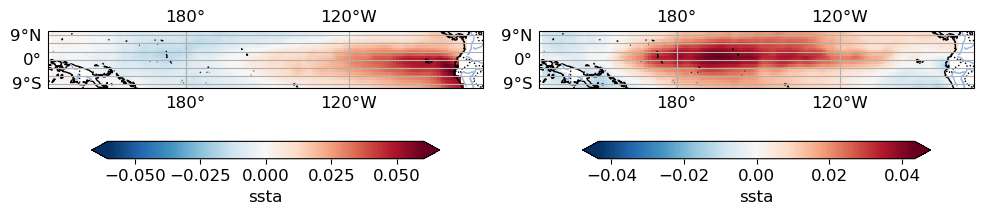

In [6]:
# E and C patterns based on first two EOFs
e_pattern = (eofs.isel(eof=0) - eofs.isel(eof=1)) / np.sqrt(2)
c_pattern = (eofs.isel(eof=0) + eofs.isel(eof=1)) / np.sqrt(2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': proj})
gpl.plot_map(e_pattern['ssta'], central_longitude=180, ax=axs[0], bar='continuous')
gpl.plot_map(c_pattern['ssta'], central_longitude=180, ax=axs[1], bar='continuous')

In [7]:
# Compute E and C index
z = sppca.transform(ds['ssta'].sel(lat=slice(-10, 10)))
z = xr.DataArray(z.T, dims=['eof', 'time'], coords={'eof': range(1, n_components+1), 'time': ds['time']})
z = z / pcs.std(dim='time')

e_index = (z.isel(eof=0) - z.isel(eof=1))/ np.sqrt(2)
c_index = (z.isel(eof=0) + z.isel(eof=1))/ np.sqrt(2)

### Regression coefficients

In [9]:
pc1_beta, _ = utstats.linear_regression_params(z.isel(eof=0),ds['ssta']) 
pc2_beta, _ = utstats.linear_regression_params(z.isel(eof=1),ds['ssta'])  
e_beta, _   = utstats.linear_regression_params(e_index ,ds['ssta']) 
c_beta, _   = utstats.linear_regression_params(c_index ,ds['ssta']) 

/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


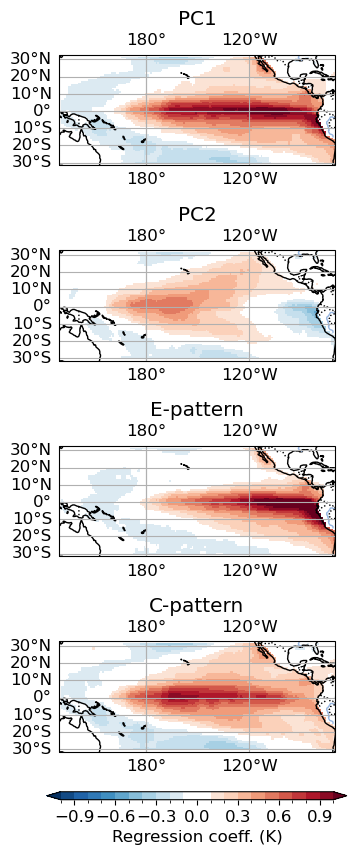

In [10]:
plparam = dict(vmin=-1, vmax=1, step=0.1, cmap='RdBu_r', bar='discrete',
               central_longitude=180, centercolor='#ffffff')

fig, axs = plt.subplots(4, 1, figsize=(5, 4*2), subplot_kw={'projection': proj})
gpl.plot_map(pc1_beta, ax=axs[0], add_bar=False, **plparam)
axs[0].set_title(rf"PC1")
gpl.plot_map(pc2_beta, ax=axs[1], add_bar=False, **plparam)
axs[1].set_title(rf"PC2")
gpl.plot_map(e_beta,   ax=axs[2], add_bar=False, **plparam)
axs[2].set_title(rf"E-pattern")
im = gpl.plot_map(c_beta,   ax=axs[3], add_bar=False, **plparam)
axs[3].set_title(rf"C-pattern")

# Shared colorbar
cbar_ax = fig.add_axes([0.2, -.01, 0.6, 0.01])
cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.7,
                    cax=cbar_ax, extend='both', label="Regression coeff. (K)")